All imports and static class Helper that contains all usefull functions for our Neural Network Training Including


* Load Datasets for Colourization and InpaintingVisualize Results / Saving
* Visualize training History dynamically using metrics / saving
* Visualize Images in Grids / Saving
* Convert Images to Grayscale using eith PIL or skimage for Exercice 11
* Create masked images  for Excersice 12
* Defining Psnr and ssim metrics
* Defining model checkpoints / early stopping / lr reducers



In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0" # Disable OneDNN optimizations for warning-free training
import numpy as np
import tensorflow as tf
from keras._tf_keras.keras.models import Model,load_model
from keras._tf_keras.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Activation, Concatenate,Multiply, Add,Dense,GlobalAveragePooling2D,Flatten,Reshape,MaxPooling2D,SpatialDropout2D,SeparableConv2D
from keras._tf_keras.keras.layers import ReLU,LeakyReLU,Dropout
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.datasets import cifar100
from keras._tf_keras.keras.backend import clear_session
from skimage.color import rgb2gray
from PIL import Image
import matplotlib.pyplot as plt
import time
import random
#</editor-fold>
class helpers:
    @staticmethod
    def write_to_file(message, file_path="output.txt"):
        with open(file_path, "a") as file:  # Open the file in append mode
            file.write(message + "\n")      # Write the message with a newline

    @staticmethod
    def display_image_grid(images, grid_size=(5, 5), title="", save_path=None, show_plot=True):
        fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
        
        # Adjust the title position by setting the 'y' parameter to place it higher
        fig.suptitle(title, fontsize=12)  # Adjust 'y' to move the title further up
        
        axes = axes.flatten()
        
        for i in range(grid_size[0] * grid_size[1]):
            ax = axes[i]
            ax.imshow(images[i], cmap='gray')
            ax.axis("off")  # Turn off the axis for clean visualization

        plt.subplots_adjust(wspace=0.05, hspace=0.05, top=2)  # Adjust 'top' for more space for title
        plt.tight_layout(pad=0.1)  # Add small padding around the grid

        # Make the figure fullscreen
        fig_manager = plt.get_current_fig_manager()
        try:
            fig_manager.window.state('zoomed')  # For TkAgg backend
        except AttributeError:
            try:
                fig_manager.window.showMaximized()  # For Qt5Agg backend
            except AttributeError:
                print("Fullscreen mode is not supported for this backend.")
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def convert_to_grayscale_pil(images):
        grayscale_images = []
        for img in images:
            pil_img = Image.fromarray(img)  # Convert NumPy array to PIL Image
            gray_img = pil_img.convert('L')  # Convert to grayscale
            grayscale_images.append(np.array(gray_img))  # Convert back to NumPy array
        return np.array(grayscale_images)

    @staticmethod
    def create_masked_images(images, mask_height, mask_width, mask_value, input_shape, num_masks):
        masked_images = np.copy(images)
        mask = np.ones((mask_height, mask_width, 3)) * mask_value

        for img in masked_images:
            for _ in range(num_masks):
                x = np.random.randint(0, input_shape[0] - mask_height)
                y = np.random.randint(0, input_shape[1] - mask_width)
                img[x:x + mask_height, y:y + mask_width, :] = mask

        return masked_images
    @staticmethod
    def create_masked_images_random_dimensions(images, mask_value, input_shape, num_masks):   
        masked_images = np.copy(images)
        for img in masked_images:
            for _ in range(num_masks):
                # Randomize mask height and width
                mask_height = np.random.randint(3, 6)  # Random height between 3 and 5
                mask_width = np.random.randint(3, 6)   # Random width between 3 and 5
                
                # Generate mask with the current dimensions
                mask = np.ones((mask_height, mask_width, input_shape[2])) * mask_value
                
                # Random position for the mask
                x = np.random.randint(0, input_shape[0] - mask_height)
                y = np.random.randint(0, input_shape[1] - mask_width)
                
                # Apply the mask
                img[x:x + mask_height, y:y + mask_width, :] = mask

        return masked_images
    @staticmethod
    def rgb_to_grayscale_skimage(images):
        return np.expand_dims(rgb2gray(images), axis=-1)

    @staticmethod
    def psnr_metric(y_true, y_pred):
        return tf.image.psnr(y_true, y_pred, max_val=1.0)

    @staticmethod
    def ssim_metric(y_true, y_pred):
        return tf.image.ssim(y_true, y_pred, max_val=1.0)

    @staticmethod
    def visualize_training_history(history, save_path=None, show_plot=True):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['psnr_metric'], label='Train PSNR')
        plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
        plt.title('PSNR vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('PSNR')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def visualize_training_history_extended(history, metrics=['loss', 'psnr_metric', 'ssim_metric'], save_path=None, show_plot=True):
        num_metrics = len(metrics)
        plt.figure(figsize=(20, 5))

        for i, metric in enumerate(metrics):
            plt.subplot(1, num_metrics, i + 1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            
            if f'val_{metric}' in history.history:
                plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            
            plt.title(f'{metric} vs. Epochs')
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()

        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def visualize_results(original, grayscale, predicted, num_images=5, save_path=None, show_plot=True):
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            plt.subplot(3, num_images, i + 1)
            plt.imshow(original[i])
            plt.axis("off")
            if i == 0: plt.title("Ground Truth")

            plt.subplot(3, num_images, i + 1 + num_images)
            plt.imshow(grayscale[i], cmap="gray")
            plt.axis("off")
            if i == 0: plt.title("Grayscale Input")

            plt.subplot(3, num_images, i + 1 + 2 * num_images)
            plt.imshow(predicted[i])
            plt.axis("off")
            if i == 0: plt.title("Colorized Output")

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Plot saved to {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    @staticmethod
    def create_model_checkpoint(model_name,save_dir, monitor='val_psnr_metric', verbose=1, save_best_only=True,mode='max'):      
        model_name = f"{model_name}.{{epoch:03d}}.keras"
        filepath = os.path.join(save_dir, model_name)
        return ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=verbose, save_best_only=save_best_only,mode=mode)

    @staticmethod
    def create_lr_reducer(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6, monitor='val_loss'):
        return ReduceLROnPlateau(monitor=monitor, factor=factor, cooldown=cooldown, patience=patience, verbose=verbose, min_lr=min_lr)

    @staticmethod
    def create_early_stopping(monitor='val_psnr_metric', patience=5, restore_best_weights=True, verbose=1,mode='max'):
        return EarlyStopping(monitor=monitor, patience=patience,restore_best_weights=restore_best_weights, verbose=verbose,mode=mode)
   
    @staticmethod
    def load_data_for_colourization(displayimages=False,showplot=False,file_path="my_saved_models"):
        # Load CIFAR-100 dataset
        (x_train, _), (x_test, _) = cifar100.load_data(label_mode='fine')  # We only need the images, not the labels so we a ignoring them
        
        start_time = time.time()
        x_train_gray = helpers.rgb_to_grayscale_skimage(x_train)
        x_test_gray = helpers.rgb_to_grayscale_skimage(x_test)
        # End time after the operation
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time
        print(f"Grayscale conversion using skimage took {elapsed_time:.4f} seconds")
        #helpers.display_image_grid(x_train_gray, grid_size=(20, 40), title="CIFAR-100 Gray Training Images using skimage")

        # Normalize the images
        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0
        x_train_gray = x_train_gray.astype('float32') / 255.0
        x_test_gray = x_test_gray.astype('float32') / 255.0

        # Split training data into train and validation sets
        x_train_gray, x_val_gray, x_train_color, x_val_color = train_test_split(x_train_gray, x_train, test_size=0.2, random_state=42)
        
        if  displayimages:
            # Display the grayscale
            save_dir = os.path.join(os.getcwd(), file_path)
            helpers.display_image_grid(x_train, grid_size=(20, 40), title="CIFAR-100 Training Images",save_path=os.path.join(save_dir, f"Training Images.png"),show_plot=showplot)
            helpers.display_image_grid(x_train_gray, grid_size=(20, 40), title="CIFAR-100 Gray Training Images using skimage",save_path=os.path.join(save_dir, f"Gray Training Images.png"),show_plot=showplot)
      
        return x_train, x_test, x_train_gray, x_test_gray, x_train_color, x_val_gray, x_val_color
  
    @staticmethod
    def load_data_for_restoration(displayimages=False,showplot=False,file_path="my_saved_models"):
        cifar100.load_data(label_mode='fine')

        # Load CIFAR-100 dataset
        (x_train, _), (x_test, _) = cifar100.load_data(label_mode='fine')  # We only need the images, not the labels so we a ignoring them
        
        img_rows = x_train.shape[1]
        img_cols = x_train.shape[2]
        channels = x_train.shape[3]

        # Show 800 images from the training dataset in a 20x40 grid just for checking
        #helpers.display_image_grid(x_train, grid_size=(20, 40), title="CIFAR-100 Training Images")
        input_shape = (32, 32, 3)
        start_time = time.time()
        x_train_masked = helpers.create_masked_images(x_train,5,5,0.5,input_shape,random.randint(2, 3)) # Masked images for training set with 5x5 mask size and 0.5 mask value and 2-3 masks per image
        x_test_masked = helpers.create_masked_images(x_test,5,5,0.5,input_shape,random.randint(2, 3)) # Masked images for test set with 5x5 mask size and 0.5 mask value and 2-3 masks per image
        # End time after the operation
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time
        print(f"Masked Images {elapsed_time:.4f} seconds")
        #helpers.display_image_grid(x_train_gray, grid_size=(20, 40), title="CIFAR-100 Gray Training Images using skimage")

        # Normalize the images
        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0
        x_train_gray = x_train_gray.astype('float32') / 255.0
        x_test_gray = x_test_gray.astype('float32') / 255.0


        # Split training data into train and validation sets
        x_train_gray, x_val_gray, x_train_color, x_val_color = train_test_split(x_train_gray, x_train, test_size=0.2, random_state=42)
        
        if  displayimages:
            # Display the grayscale
            save_dir = os.path.join(os.getcwd(), file_path)
            helpers.display_image_grid(x_train, grid_size=(20, 40), title="CIFAR-100 Training Images",save_path=os.path.join(save_dir, f"Training Images.png"),show_plot=showplot)
            helpers.display_image_grid(x_train_gray, grid_size=(20, 40), title="CIFAR-100 Masked Training Images",save_path=os.path.join(save_dir, f"Gray Training Images.png"),show_plot=showplot)
      
        return x_train, x_test, x_train_gray, x_test_gray, x_train_color, x_val_gray, x_val_color
  

  



In [2]:
# Model Classes
class AIModelBase:
    # Class variable for the default model name
    _model_name = "default_model"

    @staticmethod
    def _get_model_path():
        save_dir = os.path.join(os.getcwd(), 'my_saved_models')
        model_name = f'{AIModelBase._model_name}.keras'
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        model_path = os.path.join(save_dir, model_name)
        print(f"Save directory: {save_dir}")
        print(f"Model path: {model_path}")
        return model_path

    def __init__(self, model_name="default_model"):
        
        AIModelBase._model_name = model_name      
        self.model = self._create_model()

    def _create_model(self,metrics):
        raise NotImplementedError("Create model method not implemented")
    def train_model(self, train_data, train_labels, validation_data=None, batch_size=32, epochs=10, callbacks=None):
        """Train the model."""
        history = self.model.fit(
            train_data, train_labels,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        return history

    def evaluate_model(self, test_data, test_labels):
        """Evaluate the model."""
        return self.model.evaluate(test_data, test_labels, verbose=0)
    def predict(self, x_test):    
        return self.model.predict(x_test)      
    def save_model(self):
        """Save the model to the predefined path."""
        model_path = self._get_model_path()
        self.model.save(model_path)
        print(f"Model saved at {model_path}")

    def load_model(self):
        """Load the model from the predefined path."""
        model_path = self._get_model_path()
        self.model = tf.keras.models.load_model(model_path, custom_objects={'psnr_metric': helpers.psnr_metric})
        print(f"Model loaded from {model_path}")
        return self.model


Dynamic Function to create and run any of our models based on its name for easy use as it includes

* Creating the Call backs
* Train ModelEvaluate Model
* Display the Plots
* Display the Images for checking the quality


In [3]:
class CreateAndRunModel:
    @staticmethod
    def create_and_run_model(model_class, x_train, x_test, x_train_gray, x_test_gray, 
                             x_train_color, x_val_gray, x_val_color, save_dir, 
                             epochs=100, batch_size=32, show_plot=False):
       
        tf.random.set_seed(42) 
        np.set_printoptions(precision=10)
        # Automatically generate the model name
        model_name = f"CIFAR100-{model_class.__name__}"
        
        # Define callbacks
        callbacks = [
            helpers.create_lr_reducer(),
            helpers.create_model_checkpoint(model_name, save_dir),
            helpers.create_early_stopping()
        ]
        
        # Create the model dynamically
        my_model = model_class(model_name)
        
        # Train the model
        history = my_model.train_model( x_train_gray, x_train_color,  (x_val_gray, x_val_color),  batch_size, epochs, callbacks)
        
        # Evaluate the model
        val_loss,val_accuracy,val_psnr_metric, val_ssim_metric = my_model.evaluate_model(x_test_gray, x_test)
        
        
        # Predict and visualize results
        predicted_images = my_model.predict(x_test_gray)

        # Calculate PSNR for each image
        psnr_values = np.array([helpers.psnr_metric(x_test[i], predicted_images[i]) for i in range(len(x_test))])
        average_psnr = np.mean(psnr_values)
        top_10_indices = np.argsort(psnr_values)[-10:][::-1]
        top_10_psnr = psnr_values[top_10_indices]
        top_10_original = np.array([x_test[i] for i in top_10_indices])
        top_10_grayscale = np.array([x_test_gray[i] for i in top_10_indices])
        top_10_predicted = np.array([predicted_images[i] for i in top_10_indices])

        log=f"Model: {model_name} Epochs: {epochs} Batch Size: {batch_size} Validation Accuracy {val_accuracy} Validation Loss: {val_loss} Validation PSNR: {val_psnr_metric}  SSIM: {val_ssim_metric} Average PSNR: {average_psnr} Top 10 PSNR: {top_10_psnr}"
        print(log)
        helpers.write_to_file(log,file_path=os.path.join(save_dir, f"Colourization_results.txt"))

        helpers.visualize_training_history_extended(
            history, metrics=['loss','accuracy', 'psnr_metric', 'ssim_metric'],
            save_path=os.path.join(save_dir, f"{model_name}_training_history.png"),
            show_plot=show_plot
        )
        helpers.visualize_results(
            x_test[:10], x_test_gray[:10], predicted_images[:10],num_images=10,
            save_path=os.path.join(save_dir, f"{model_name}_results.png"),
            show_plot=show_plot
        )

        helpers.visualize_results(
            original=top_10_original,
            grayscale=top_10_grayscale,
            predicted=top_10_predicted,
            num_images=10,
            save_path=os.path.join(save_dir, f"{model_name}_Top10results.png"),
            show_plot=show_plot
        )
        helpers.display_image_grid(
            predicted_images, grid_size=(20, 40),
            title=f"CIFAR-100 Gray Predicted Images {model_name}",
            save_path=os.path.join(save_dir, f"{model_name}_Predicted Images.png"),
            show_plot=show_plot
        )



Our AutoEncoder to Run

In [4]:
class ConvAutoEncoderForColourizationUNet4(AIModelBase):
    
    def __init__(self, model_name="default_model"):
        super().__init__(model_name)
    def _create_model(self,metrics=["accuracy",helpers.psnr_metric, helpers.ssim_metric]):
  
        # Hyperparameters
        kernel_size = 3        
        
        # Encoder
        inputs = Input(shape=(32, 32, 1), name="input_layer")
        
        # First block
        x = Conv2D(64, kernel_size, activation="relu", padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(64, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        encoder_output1 = x  # Save output for skip connection
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        # Second block
        x = Conv2D(128, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        encoder_output2 = x  # Save output for skip connection
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        # Third block
        x = Conv2D(256, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        encoder_output3 = x  # Save output for skip connection
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        # Bottleneck
        x = Conv2D(512, kernel_size, activation="relu", padding="same")(x)
        #x = BatchNormalization()(x)
        x = Conv2D(512, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        
        # Decoder
        # Third block (reverse)
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(256, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Concatenate()([x, encoder_output3])
        x = Conv2D(256, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        
        # Second block (reverse)
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(128, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Concatenate()([x, encoder_output2])
        x = Conv2D(128, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        
        # First block (reverse)
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(64, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Concatenate()([x, encoder_output1])
        x = Conv2D(64, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, kernel_size, activation="relu", padding="same")(x)
        x = BatchNormalization()(x)
        
        # Output layer
        outputs = Conv2D(3, kernel_size, activation="sigmoid", padding="same", name="output_layer")(x)
        
        # Model
        autoencoder = Model(inputs, outputs, name="ColorizationAutoencoder")
        autoencoder.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),
            metrics=metrics
        )
        
        # Summary
        autoencoder.summary()
        
        
        return autoencoder      

Running the model using the helper function

Grayscale conversion using skimage took 0.6948 seconds
Fullscreen mode is not supported for this backend.
Plot saved to /kaggle/working/my_saved_models/Training Images.png


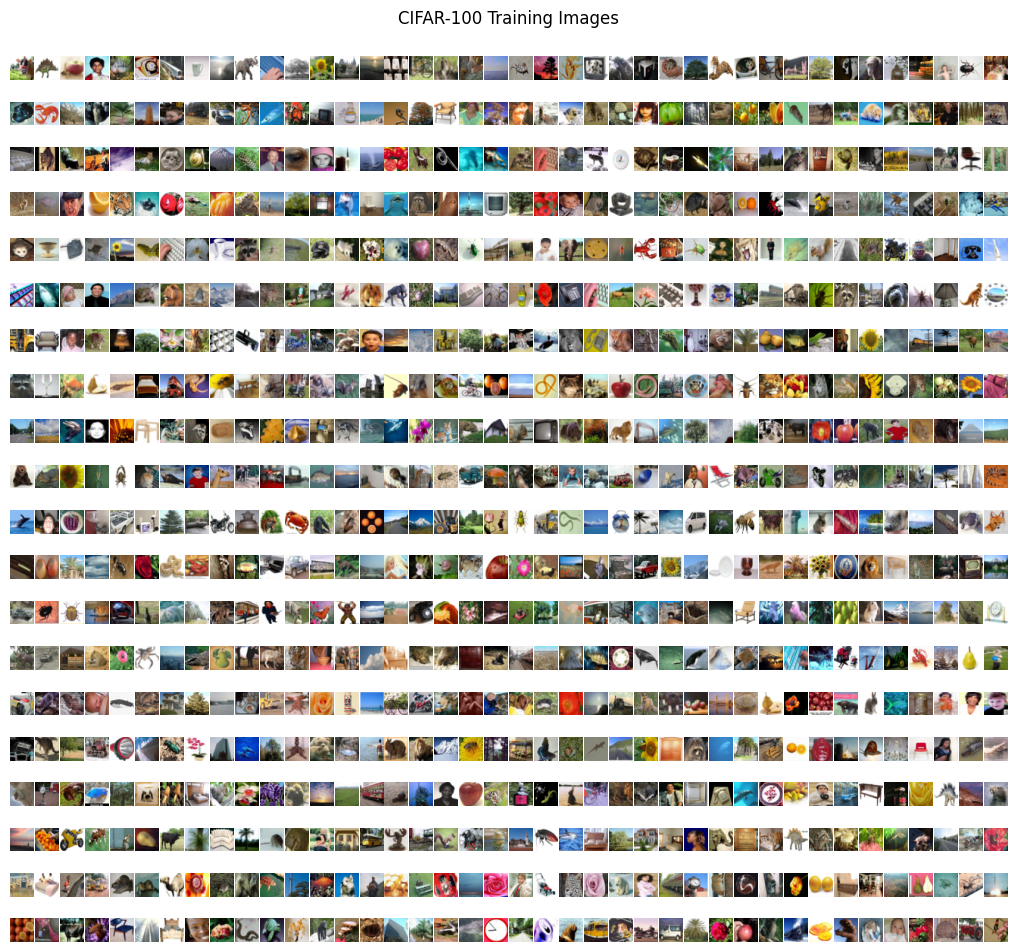

Fullscreen mode is not supported for this backend.
Plot saved to /kaggle/working/my_saved_models/Gray Training Images.png


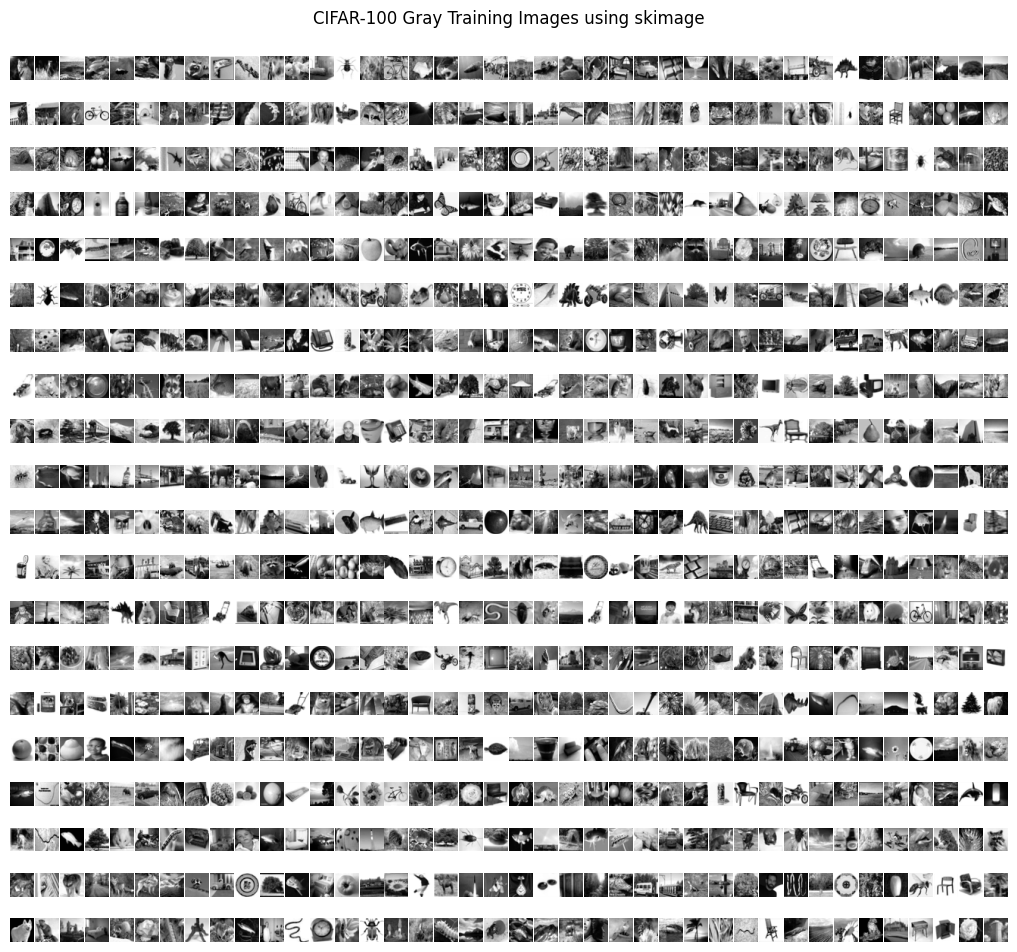

Model: "ColorizationAutoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 512) │  2,359,808 │ conv2d_6[0][0]  

 Total params: 8,569,027 (32.69 MB)

 Trainable params: 8,563,523 (32.67 MB)

 Non-trainable params: 5,504 (21.50 KB)

Epoch 1/100


I0000 00:00:1733649478.819919     428 service.cc:145] XLA service 0x7cf544004210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733649478.819961     428 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733649478.819964     428 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733649479.282998     428 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1733649479.284217     428 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1733649479.285482     428 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1733649479.286190     428 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1733649479.287074     428 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1733649479.287689     428 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Asse

  2/625 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.3370 - loss: 0.1258 - psnr_metric: 9.2463 - ssim_metric: 0.0188   

I0000 00:00:1733649489.731075     428 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4111 - loss: 0.0220 - psnr_metric: 18.6086 - ssim_metric: 0.6386

W0000 00:00:1733649529.513015     426 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1733649529.514268     426 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1733649529.515722     426 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1733649529.516529     426 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1733649529.517519     426 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1733649529.518161     426 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
W0000 00:00:1733649533.018228     427 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1733649533.018414     427 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1733649533.018844     427 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1733649533.019016     427 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Asser


Epoch 1: val_psnr_metric improved from -inf to 14.81533, saving model to /kaggle/working/my_saved_models/CIFAR100-ConvAutoEncoderForColourizationUNet4.001.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 73ms/step - accuracy: 0.4111 - loss: 0.0220 - psnr_metric: 18.6116 - ssim_metric: 0.6389 - val_accuracy: 0.4433 - val_loss: 0.0385 - val_psnr_metric: 14.8153 - val_ssim_metric: 0.5550 - learning_rate: 1.0000e-04
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4904 - loss: 0.0098 - psnr_metric: 22.1342 - ssim_metric: 0.8854
Epoch 2: val_psnr_metric improved from 14.81533 to 22.06546, saving model to /kaggle/working/my_saved_models/CIFAR100-ConvAutoEncoderForColourizationUNet4.002.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.4905 - loss: 0.0098 - psnr_metric: 22.1343 - ssim_metric: 0.8854 - val_accuracy: 0.4780 - val_loss: 0.0099 - val_psnr_metric: 22.0655 - val_ssim_metric: 0.8860 - learning_rate: 1.0000e-04
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/s

W0000 00:00:1733650137.202733     428 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1733650137.202925     428 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Model: CIFAR100-ConvAutoEncoderForColourizationUNet4 Epochs: 100 Batch Size: 64 Validation Accuracy 0.5182386636734009 Validation Loss: 0.008844908326864243 Validation PSNR: 23.10235595703125  SSIM: 0.9057245850563049 Average PSNR: 23.10234832763672 Top 10 PSNR: [35.728752 35.68516  35.4542   35.42481  34.882782 34.872818 34.851284
 34.83009  34.797974 34.7437  ]
Plot saved to /kaggle/working/my_saved_models/CIFAR100-ConvAutoEncoderForColourizationUNet4_training_history.png


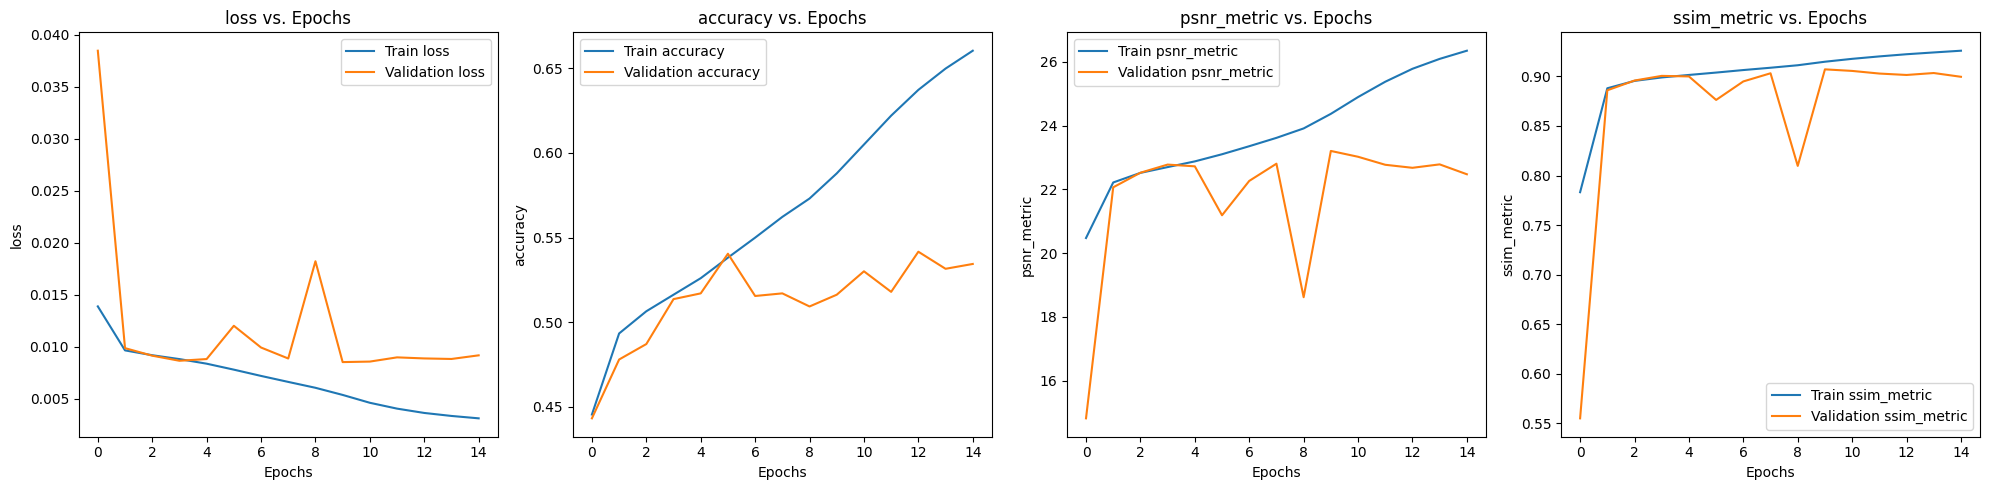

Plot saved to /kaggle/working/my_saved_models/CIFAR100-ConvAutoEncoderForColourizationUNet4_results.png


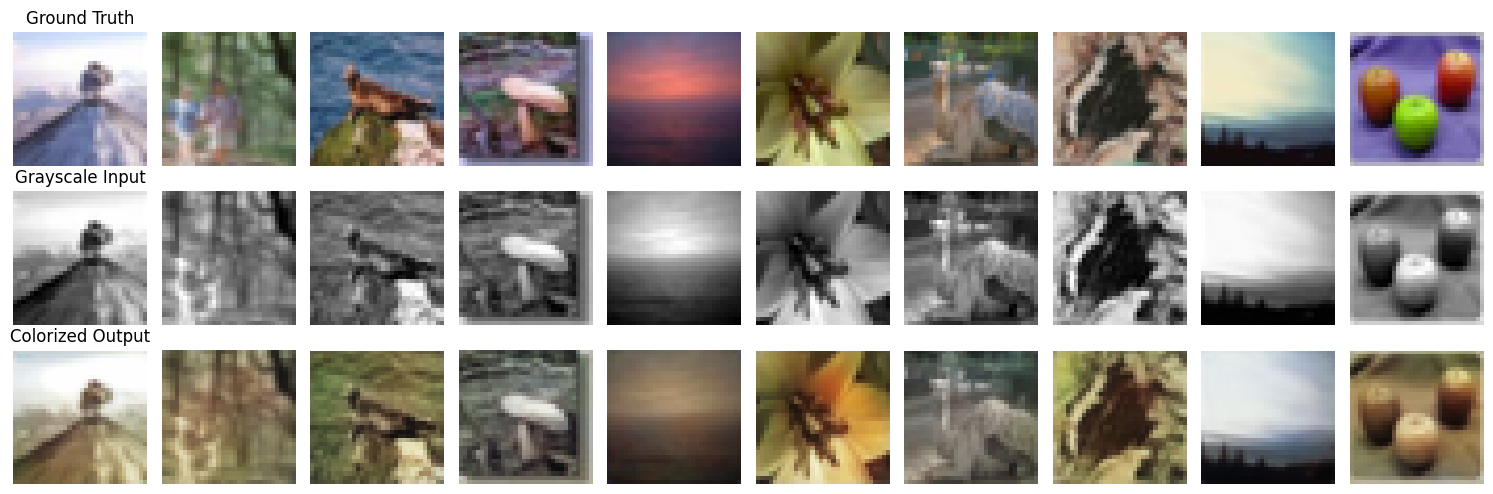

Plot saved to /kaggle/working/my_saved_models/CIFAR100-ConvAutoEncoderForColourizationUNet4_Top10results.png


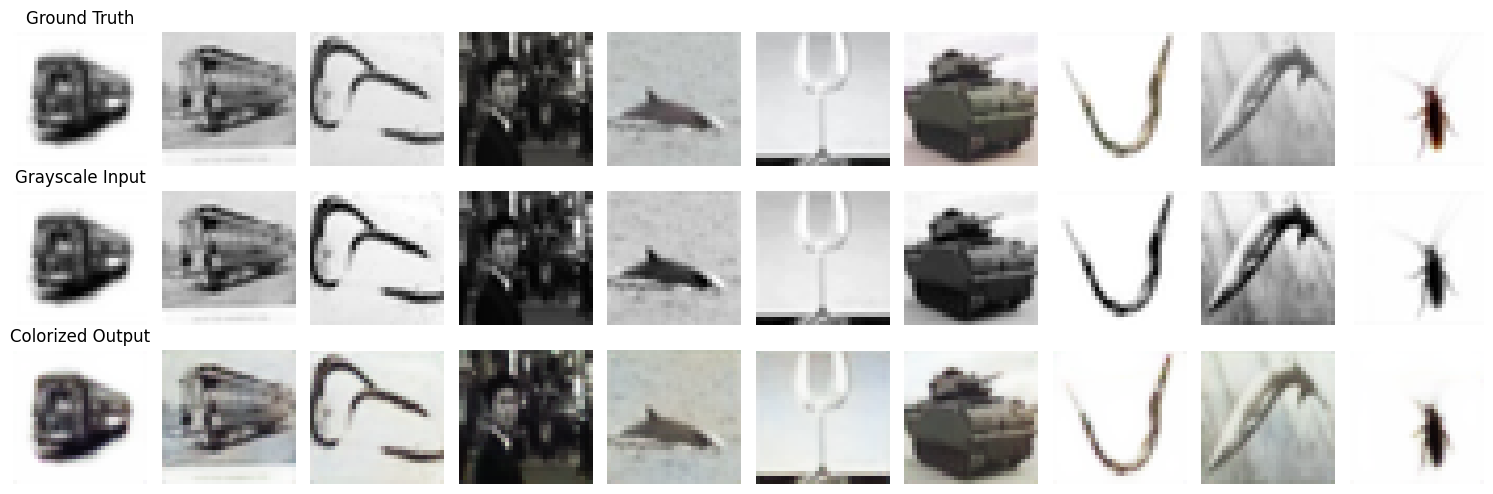

Fullscreen mode is not supported for this backend.
Plot saved to /kaggle/working/my_saved_models/CIFAR100-ConvAutoEncoderForColourizationUNet4_Predicted Images.png


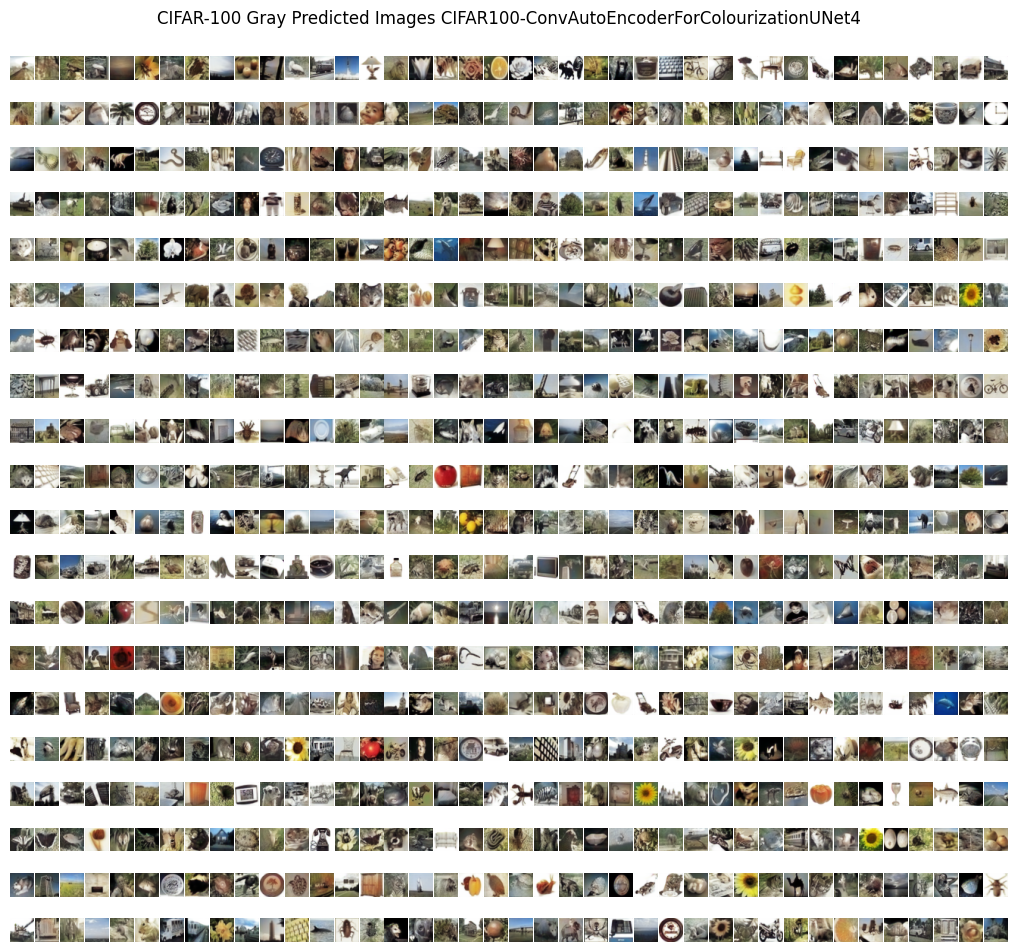

In [5]:
save_dir = os.path.join(os.getcwd(), 'my_saved_models')
os.makedirs(save_dir, exist_ok=True)
show_plot=True
display_images=True
x_train, x_test, x_train_gray, x_test_gray, x_train_color, x_val_gray, x_val_color=helpers.load_data_for_colourization(display_images,show_plot)
epochs=100
batch_size=64

CreateAndRunModel.create_and_run_model(
    ConvAutoEncoderForColourizationUNet4,
    np.copy(x_train), np.copy(x_test), np.copy(x_train_gray), np.copy(x_test_gray), np.copy(x_train_color), 
    np.copy(x_val_gray), np.copy(x_val_color), save_dir, epochs, batch_size, show_plot=show_plot
)
